*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you will predict healthcare costs using a regression algorithm.

You are given a dataset that contains information about different people including their healthcare costs. Use the data to predict healthcare costs based on new data.

The first two cells of this notebook import libraries and the data.

Make sure to convert categorical data to numbers. Use 80% of the data as the `train_dataset` and 20% of the data as the `test_dataset`.

`pop` off the "expenses" column from these datasets to create new datasets called `train_labels` and `test_labels`. Use these labels when training your model.

Create a model and train it with the `train_dataset`. Run the final cell in this notebook to check your model. The final cell will use the unseen `test_dataset` to check how well the model generalizes.

To pass the challenge, `model.evaluate` must return a Mean Absolute Error of under 3500. This means it predicts health care costs correctly within $3500.

The final cell will also predict expenses using the `test_dataset` and graph the results.

In [1]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [2]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2021-03-26 11:06:16--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘insurance.csv.1’

insurance.csv.1         [ <=>                ]  49.09K  --.-KB/s    in 0.01s   

2021-03-26 11:06:16 (4.13 MB/s) - ‘insurance.csv.1’ saved [50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [3]:
# split data and separate labels
train_dataset, test_dataset = train_test_split(dataset, test_size=.2, random_state=123)
train_labels = train_dataset.pop('expenses')
test_labels = test_dataset.pop('expenses')

In [4]:
train_dataset.info()  # no nulls

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1070 entries, 67 to 1122
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1070 non-null   int64  
 1   sex       1070 non-null   object 
 2   bmi       1070 non-null   float64
 3   children  1070 non-null   int64  
 4   smoker    1070 non-null   object 
 5   region    1070 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 58.5+ KB


In [5]:
train_dataset.describe()

,age,bmi,children
count,1070.000000,1070.000000,1070.000000
mean,39.124299,30.646916,1.082243
std,14.114475,6.021244,1.221404
min,18.000000,16.000000,0.000000
25%,26.000000,26.400000,0.000000
50%,39.000000,30.300000,1.000000
75%,51.000000,34.575000,2.000000
max,64.000000,53.100000,5.000000


In [6]:
train_dataset[['region', 'sex', 'smoker']].describe()

,region,sex,smoker
count,1070,1070,1070
unique,4,2,2
top,southeast,male,no
freq,298,541,856


In [7]:
# encode categorical variables
sex_encoder = OrdinalEncoder().fit(train_dataset[['sex']])
smoker_encoder = OrdinalEncoder().fit(train_dataset[['smoker']])
region_encoder = OneHotEncoder(sparse=False, drop='first').fit(train_dataset[['region']])

In [8]:
pd.options.mode.chained_assignment = None  # supress warnings

train_dataset[['sex']] = sex_encoder.transform(train_dataset[['sex']])
train_dataset[['smoker']] = smoker_encoder.transform(train_dataset[['smoker']])
train_dataset[['region_0', 'region_1', 'region_2']] = region_encoder.transform(train_dataset[['region']])
train_dataset.drop('region', axis=1, inplace=True)

train_dataset.head()

,age,sex,bmi,children,smoker,region_0,region_1,region_2
67,40,1.0,26.3,1,0.0,1.0,0.0,0.0
736,37,0.0,38.4,0,1.0,0.0,1.0,0.0
310,50,1.0,26.6,0,0.0,0.0,0.0,1.0
963,46,1.0,24.8,3,0.0,0.0,0.0,0.0
680,21,0.0,17.4,1,0.0,0.0,0.0,1.0


In [9]:
# normalization
cols = train_dataset.columns

scaler = MinMaxScaler()

train_dataset = pd.DataFrame(scaler.fit_transform(train_dataset), columns=cols)
train_dataset.head()

,age,sex,bmi,children,smoker,region_0,region_1,region_2
0,0.478261,1.0,0.277628,0.2,0.0,1.0,0.0,0.0
1,0.413043,0.0,0.603774,0.0,1.0,0.0,1.0,0.0
2,0.695652,1.0,0.285714,0.0,0.0,0.0,0.0,1.0
3,0.608696,1.0,0.237197,0.6,0.0,0.0,0.0,0.0
4,0.065217,0.0,0.037736,0.2,0.0,0.0,0.0,1.0


In [10]:
# first we're gonna try with a multiple linear regression

# build the model
linear_model = tf.keras.Sequential([
                                    layers.Dense(units=1)
])

linear_model.predict(train_dataset[:5])

array([[ 0.69917774],
       [-0.19950852],
       [ 0.56071043],
       [ 0.4934538 ],
       [ 0.13194253]], dtype=float32)

In [11]:
# compile the model
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [12]:
# train the model
history = linear_model.fit(
    train_dataset, train_labels, 
    epochs=7000,
    verbose=0,
    validation_split=0.2)

In [13]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.title('History')
  plt.xlabel('Epoch')
  plt.ylabel('Error [expenses]')
  plt.legend()
  plt.grid(True)

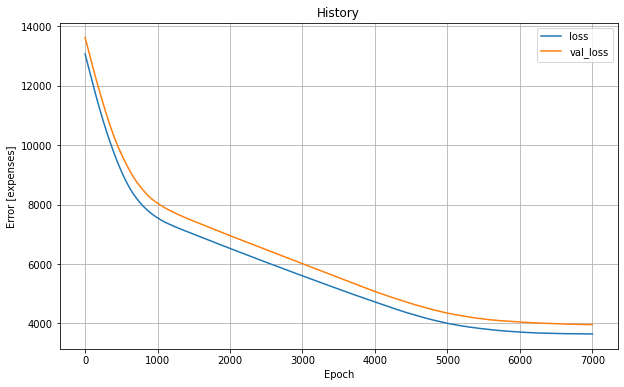

In [14]:
plot_loss(history)

In [15]:
# let´s see if a DNN model can improve the results
def build_and_compile_model():
  model = keras.Sequential([
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [16]:
dnn_model = build_and_compile_model()

In [17]:
history = dnn_model.fit(
    train_dataset, 
    train_labels,
    validation_split=0.2,
    verbose=0, 
    epochs=500)

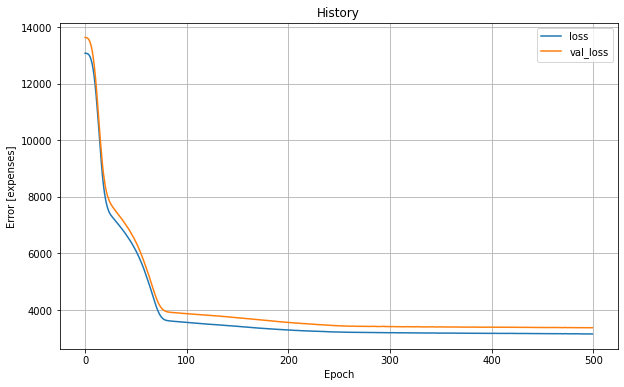

In [18]:
plot_loss(history)

In [19]:
# train the final model
model = build_and_compile_model()
model.fit(
    train_dataset, 
    train_labels,
    verbose=0,
    epochs=200)

In [20]:
# check nan in test set
test_dataset.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
dtype: int64

In [21]:
# transform test dataset
test_dataset[['sex']] = sex_encoder.transform(test_dataset[['sex']])
test_dataset[['smoker']] = smoker_encoder.transform(test_dataset[['smoker']])
test_dataset[['region_0', 'region_1', 'region_2']] = region_encoder.transform(test_dataset[['region']])
test_dataset.drop('region', axis=1, inplace=True)


cols = test_dataset.columns

test_dataset = pd.DataFrame(scaler.transform(test_dataset), columns=cols)
test_dataset.head()

,age,sex,bmi,children,smoker,region_0,region_1,region_2
0,0.673913,0.0,0.719677,0.4,0.0,0.0,1.0,0.0
1,0.304348,1.0,0.574124,0.2,0.0,0.0,0.0,0.0
2,0.195652,0.0,0.415094,0.0,1.0,0.0,0.0,1.0
3,0.369565,1.0,0.218329,0.2,0.0,1.0,0.0,0.0
4,0.913043,1.0,0.261456,0.0,0.0,0.0,1.0,0.0


9/9 - 0s - loss: 2730.2683
Testing set Mean Abs Error: 2730.27 expenses
You passed the challenge. Great job!


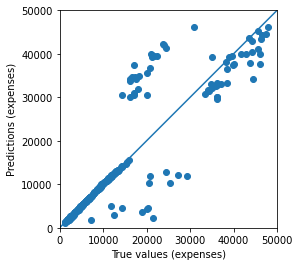

In [22]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
mae = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
